In [4]:
import ctypes
from ctypes import *
import numpy as np
from precisionFuncs import *
from cpp_wrappers import fit2DGaussian_wrap

In [6]:
readPTU = ctypes.WinDLL (r"S:\64bit dll 's\PQ_PTU_sf\release\PQ_PTU.dll")
mydll = WinDLL(r"K:\vanderVoortN\FRC\dev\csandbox\toydll\mydll.dll")

## Write wrapper for test functions

In [130]:
%%file functions.c


#define SMBUS_API __declspec(dllexport)
#define SMB_MAX_DATA_SIZE 5
#include <stdlib.h>

typedef void* SMBUS_HANDLE;

typedef struct _SMB_REQUEST
{
    unsigned char Address;
    unsigned char Command;
    unsigned char BlockLength;
    unsigned char Data[SMB_MAX_DATA_SIZE];
    unsigned char** ppDat;
} SMB_REQUEST;

SMBUS_API int SmBusReadByte(SMBUS_HANDLE handle,SMB_REQUEST *request)
{
    unsigned char i;
    for(i = 0; i < request->BlockLength; i++)
        request::Data[i] = i;
    request->ppDat = malloc(4);
    
    return request->BlockLength;
}

SMBUS_API SMBUS_HANDLE OpenSmbus(void)
{
    return (void*)0x12345678;
}

#include <stdlib.h>

__declspec(dllexport) void __stdcall Foo(unsigned char** ppMem, int* pSize)
{
    char i;
    *pSize = 4;
    *ppMem = (unsigned char*)malloc(*pSize);
    for(i = 0; i < *pSize; i++)
        (*ppMem)[i] = i;
}

Overwriting functions.c


In [131]:
#!gcc -c -Wall -O2 -Wall -ansi -pedantic -fPIC -o functions.o functions.c
!gcc -c -o functions.o functions.c
!gcc -o libfunctions.dll -shared functions.o

functions.c: In function 'SmBusReadByte':
functions.c:22:17: error: expected expression before ':' token
         request::Data[i] = i;
                 ^


In [128]:
%%file run_struct_func_c

from ctypes import *
SMB_MAX_DATA_SIZE = 5
ARRAY5 = c_ubyte * SMB_MAX_DATA_SIZE

class SMB_REQUEST(Structure):
    _fields_ = [
        ("Address", c_ubyte),
        ("Command", c_ubyte),
        ("BlockLength", c_ubyte),
        ("Data", ARRAY5),
        ("ppDAT", POINTER(POINTER(c_ubyte)))]

smbus_read_byte = CDLL('libfunctions').SmBusReadByte
smbus_read_byte.argtypes = [c_void_p,POINTER(SMB_REQUEST)]
smbus_read_byte.restype = c_int
open_smbus = CDLL('libfunctions').OpenSmbus
open_smbus.argtypes = []
open_smbus.restype = c_void_p

handle = open_smbus()
print ('handle = %08Xh' % handle)

smb_request = SMB_REQUEST(1,2,5)

print ('returned =',smbus_read_byte(handle,byref(smb_request)))
print ('Address =',smb_request.Address)
print ('Command =',smb_request.Command)
print ('BlockLength =',smb_request.BlockLength)
for i,b in enumerate(smb_request.Data):
    print ('Data[%d] = %02Xh' % (i,b))
    
Foo = CDLL('libfunctions').Foo
Foo.argtypes = [POINTER(POINTER(c_ubyte)),POINTER(c_int)]
mem = POINTER(c_ubyte)()
size = c_int(0)
Foo(byref(mem),byref(size))
print(size.value,mem[0],mem[1],mem[2],mem[3])

Overwriting run_struct_func_c


In [129]:
!python run_struct_func_c

handle = 12345678h


Traceback (most recent call last):
  File "run_struct_func_c", line 26, in <module>
    print ('returned =',smbus_read_byte(handle,byref(smb_request)))
OSError: exception: access violation writing 0x0000000000000000


In [11]:
#fpin = ctypes.create_string_buffer(b"K:\\vanderVoortN\\python\\FRC\\PQSpcm_2019-02-01_16-37-57.ptu")#medium file
#fpin = ctypes.create_string_buffer(b"K:\\vanderVoortN\\python\\FRC\\Alexa594_exc561_0perc_0017AU1.ptu")#small file
fpin = ctypes.create_string_buffer(b"K:\\vanderVoortN\\python\\FRC\\Alexa594_exc561_80perc_00630AU1.ptu") #big file
fpout = ctypes.create_string_buffer(b"K:\\vanderVoortN\\python\\FRC\\fout.txt")
NumRecords = readPTU.PQ_ptuHeader_sf(fpin,fpout)
print(NumRecords)

195519853


## initialize c compatible variables for reading PTU files

In [12]:
c_longlong_p = ctypes.POINTER(ctypes.c_longlong) #init class for long long pointer
c_ubyte_p = ctypes.POINTER(ctypes.c_ubyte) #init class for unsigned char pointer
c_int_p = ctypes.POINTER(ctypes.c_int) #init class for int pointer


length = ctypes.c_longlong(NumRecords)

eventN = np.zeros(NumRecords).astype(np.int64)
eventN_p = eventN.ctypes.data_as(c_longlong_p)

tac = np.zeros(NumRecords).astype(np.int)
tac_p = tac.ctypes.data_as(c_int_p)

t = np.zeros(NumRecords).astype(np.int64)
t_p = t.ctypes.data_as(c_longlong_p)

can = np.zeros(NumRecords).astype(np.uint)
can_p = can.ctypes.data_as(c_ubyte_p)

j = ctypes.c_longlong()
ov_in = ctypes.c_longlong()
stage = ctypes.c_int()



In [6]:
mydll._Z9printfuncPcxPxPiPh(fpin, length, eventN_p, tac_p, can_p)

162842

## Read in PTU files using picoquant routine

In [13]:
readPTU.PQ_ptu_sf(fpin, length, eventN_p, tac_p, t_p, can_p, ctypes.byref(j), ov_in, stage)

-885047296

In [67]:
from PIL import Image
import matplotlib.pyplot as plt

In [68]:
im = Image.open(r"K:\vanderVoortN\python\FRC\PQSpcm_2019-02-01_15-59-23-gate0-25.tiff")
imarray = np.array(im, dtype = np.uint8)

## Read in GaussFit from Suren

In [2]:
import ctypes
from ctypes import *
import numpy as np
from precisionFuncs import *
from cpp_wrappers import fit2DGaussian_wrap

In [28]:
def fit2DGaussian_wrap(params0, a, im):
    """wrapper to fit2DGaussian function from cpp used in Ani Fitting routine
    params0: initial guess for parameters. They are ordered according to Mortensen et al.
    im: 2D Gauss image to be fitted
    a: pixel size"""
    
    #ISSUE: class declaration occurs inside of function, this disables use outside of current
    #function. It cannot be changed easily as imsize must be known for class initialisation.
    
    fit2DGaussian = ctypes.WinDLL(r"K:\vanderVoortN\FRC\dev\Fit2DGaussian\x64\Debug\Fit2DGaussian.dll").fit2DGaussian

    c_double_p = ctypes.POINTER(ctypes.c_double)
    im = im.flatten()
    imsize = im.shape[0]
    DOUBLEARRAY = ctypes.c_double * imsize

    class LVDoubleArray(ctypes.Structure):
        _fields_ = [
            ('length', ctypes.c_int),#length of array i.e. imsize
            ('data', DOUBLEARRAY) #image array
        ]

    class MGPARAM(ctypes.Structure):
        _fields_ = [
            ('subimage', ctypes.POINTER(ctypes.POINTER(LVDoubleArray))),
            ('osize', ctypes.c_int), #number or rows in squared image
            ('M', ctypes.POINTER(ctypes.POINTER(LVDoubleArray)))
        ]
    #give paramaters in correct format
    variables = np.zeros(10, dtype = np.double).ctypes.data_as(c_double_p)
    variables[0] = params0[0] / a#ux
    variables[1] = params0[1] / a#uy
    variables[3] = params0[2] / a#sx = s
    variables[2] = params0[4] /(variables[3]**2 * 2*np.pi)#N
    variables[4] = 1 #ellipticity, for circular 1
    variables[5] = params0[3]**2#b
    variables[6] = 0#info from optimization algorithm
    variables[7] = 1#bool fr weight or no weight: Ask Suren for correct setting1
    variables[8] = 0#bool if background is fitted: 0 -> background is fitted
    variables[9] = 1#bool for ellipticity: 1 means circular, 0 means elliptical
    
#    for i in range(9):
#        print('variables element %i has value %f'%(i, variables[i]))

    c_double_p = ctypes.POINTER(ctypes.c_double)
    fit2DGaussian.argtypes = [ctypes.POINTER(ctypes.c_double), ctypes.POINTER(MGPARAM)]
    fit2DGaussian.restypes = ctypes.c_double

    c_im = DOUBLEARRAY()
    c_M = DOUBLEARRAY()

    for i, el in enumerate(im):
        c_im[i] = el
        c_M[i] = 1

    c_imsize = ctypes.c_int(imsize)
    c_osize = ctypes.c_int(int(np.sqrt(imsize)))
    print('osize is ' + str(c_osize))


    subimage = ctypes.pointer(LVDoubleArray(c_imsize, c_im))
    subM = ctypes.pointer(LVDoubleArray(c_imsize, c_M))
    mgparam = MGPARAM(ctypes.pointer(subimage), c_osize, ctypes.pointer(subM))
    fit2DGaussian(variables, mgparam)
    
    params = np.zeros(5)
    params[0] = (variables[0]+0.5) * a
    params[1] = (variables[1]+0.5) *a
    params[2] = variables[3] * a
    params[3] = np.sqrt(variables[5])
    params[4] = variables[2]
    return params

[453.23321288616955, 445.9068843017808, 52.94983903998185, 9.681181369748473e-07, 110.28260572424318]
osize is c_long(20)
[4.98195900e+02 5.00773186e+02 4.40168164e+01 9.68118137e-07
 1.99202601e+01]


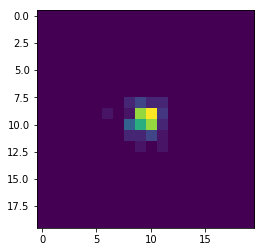

In [34]:
import ctypes
from ctypes import *
import numpy as np
from precisionFuncs import *
from cpp_wrappers import fit2DGaussian_wrap
import matplotlib.pyplot as plt
params0 = [500.,500.,50.,1e-6,100.]
a = 50
imsize = 1000

im = createGaussImg(imsize / a, params0, a)
#im = np.arange(441)
randparams = []
#for i in range(10000000):
#    im = createGaussImg(imsize / a, params0, a)

for el in params0:
    randparams.append( el*(0.8 +np.random.rand()*0.4))
print(randparams)
fitparams, tIstar = fit2DGaussian_wrap(randparams, a, im)
print(fitparams)
plt.imshow(im)
plt.colorbar
plt.show()


In [127]:
tIstar

0

In [68]:
%%file toy2DGauss.cpp
#include <cstdio>

typedef struct {
  int length;
  double data[1];
} LVDoubleArray;

typedef struct {
	LVDoubleArray** subimage;
	int osize;
	LVDoubleArray** M;
} MGParam;

double fit2DGaussian(double* vars, MGParam* p)
{
	// vars = [x0 y0 A sigma_x sigma_y bg info wi_nowi free_fixed_bg]
    vars[8] = 42;
    LVDoubleArray *subimage = *(p->subimage);
    LVDoubleArray *M = *(p->M);
    int length = subimage->length;
    int i;
    double *imdat = subimage->data, *mdat = M->data;
    printf("size of mdat is %i", sizeof(&mdat));

    for ( i=0; i < 400; i++){
        mdat[i] = imdat[i];
//        printf("value of imdat at position %i  is %f\n",i, mdat[i]);
    };
    printf("succesfull loop completion \n");
    
  return 1;
}

Overwriting toy2DGauss.cpp


In [244]:
!gcc -c -o toy2DGauss.o toy2DGauss.cpp
!gcc -o fit2DGaussian.dll -shared toy2DGauss.o

In [ ]:
np.cos()